In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, RFECV, SelectKBest ,chi2
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('bank-marketing.csv')
dataset.head()

age           job  salary  marital  education targeted default  balance  \
0   58    management  100000  married   tertiary      yes      no     2143   
1   44    technician   60000   single  secondary      yes      no       29   
2   33  entrepreneur  120000  married  secondary      yes      no        2   
3   47   blue-collar   20000  married    unknown       no      no     1506   
4   33       unknown       0   single    unknown       no      no        1   

  housing loan  contact  day month  duration  campaign  pdays  previous  \
0     yes   no  unknown    5   may       261         1     -1         0   
1     yes   no  unknown    5   may       151         1     -1         0   
2     yes  yes  unknown    5   may        76         1     -1         0   
3     yes   no  unknown    5   may        92         1     -1         0   
4      no   no  unknown    5   may       198         1     -1         0   

  poutcome response  
0  unknown       no  
1  unknown       no  
2  unknown       no  
3  unknown       no  
4  unknown       no

In [3]:
dataset.isna().sum()

age          0
job          0
salary       0
marital      0
education    0
targeted     0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
response     0
dtype: int64

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
age          45211 non-null int64
job          45211 non-null object
salary       45211 non-null int64
marital      45211 non-null object
education    45211 non-null object
targeted     45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
response     45211 non-null object
dtypes: int64(8), object(11)
memory usage: 6.6+ MB


# Describe Data

### 1. Describe the pdays column, make note of the mean, median and minimum values. Anything fishy in the values?

In [5]:
dataset.describe()

age         salary        balance           day      duration  \
count  45211.000000   45211.000000   45211.000000  45211.000000  45211.000000   
mean      40.936210   57006.171065    1362.272058     15.806419    258.163080   
std       10.618762   32085.718415    3044.765829      8.322476    257.527812   
min       18.000000       0.000000   -8019.000000      1.000000      0.000000   
25%       33.000000   20000.000000      72.000000      8.000000    103.000000   
50%       39.000000   60000.000000     448.000000     16.000000    180.000000   
75%       48.000000   70000.000000    1428.000000     21.000000    319.000000   
max       95.000000  120000.000000  102127.000000     31.000000   4918.000000   

           campaign         pdays      previous  
count  45211.000000  45211.000000  45211.000000  
mean       2.763841     40.197828      0.580323  
std        3.098021    100.128746      2.303441  
min        1.000000     -1.000000      0.000000  
25%        1.000000     -1.000000      0.000000  
50%        2.000000     -1.000000      0.000000  
75%        3.000000     -1.000000      0.000000  
max       63.000000    871.000000    275.000000

Here the pdays values are positively skewed the values of pdays are as follows:
min = -1.000000
mean = 40.197828
median = -1
max = 871.000000. The standard deviation is greater than mean along with mean and median values are also very different, that means it's highly dispersed.

### 2. Describe the pdays column again, this time limiting yourself to the relevant values of pdays. How different are the mean and the median values?

In [6]:
print('Pdays Mean: ', dataset['pdays'].mean())
print('Pdays Median: ', dataset['pdays'].median())

Pdays Mean:  40.19782796222158
Pdays Median:  -1.0


From above values it seems the data is highly spreaded

### 3. Plot a horizontal bar graph with the median values of balance for each education level value. Which group has the highest median?

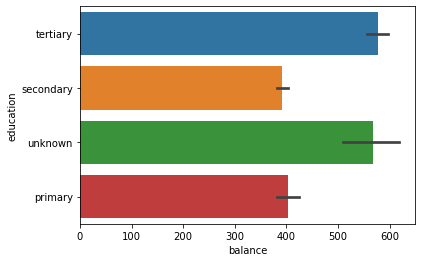

In [7]:
from numpy import median
sns.barplot(x="balance", y="education", data=dataset, estimator=median)

From above graph, we can see that tertiary education has highest median for balance

### 4. Make a box plot for pdays. Do you see any outliers?

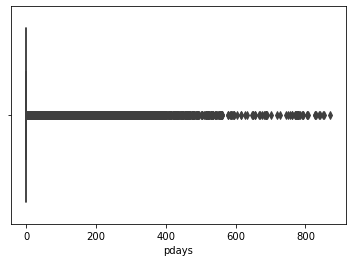

In [8]:
sns.boxplot(x=dataset['pdays'])

Yes, there are values so much far from the mean, which are nothing but the outliers. So let's remove the values more than 500

In [9]:
dataset[dataset['pdays'] > 300].count()

age          2470
job          2470
salary       2470
marital      2470
education    2470
targeted     2470
default      2470
balance      2470
housing      2470
loan         2470
contact      2470
day          2470
month        2470
duration     2470
campaign     2470
pdays        2470
previous     2470
poutcome     2470
response     2470
dtype: int64

In [10]:
dataset.drop(dataset[dataset['pdays'] > 300].index, inplace=True)

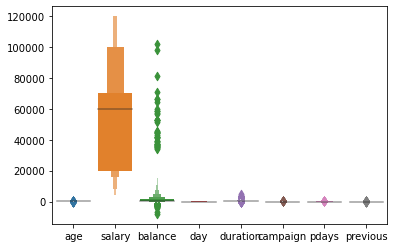

In [11]:
sns.boxenplot(data=dataset)

In [12]:
dataset[dataset['balance'] > 20000].count()

age          184
job          184
salary       184
marital      184
education    184
targeted     184
default      184
balance      184
housing      184
loan         184
contact      184
day          184
month        184
duration     184
campaign     184
pdays        184
previous     184
poutcome     184
response     184
dtype: int64

In [13]:
dataset.drop(dataset[dataset['balance'] > 20000].index, inplace=True)

### Let's convert the output value to number to perform bivariate analysis

In [14]:
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
dataset_new = dataset.copy()
dataset_new['response'] = l.fit_transform(dataset_new['response'])

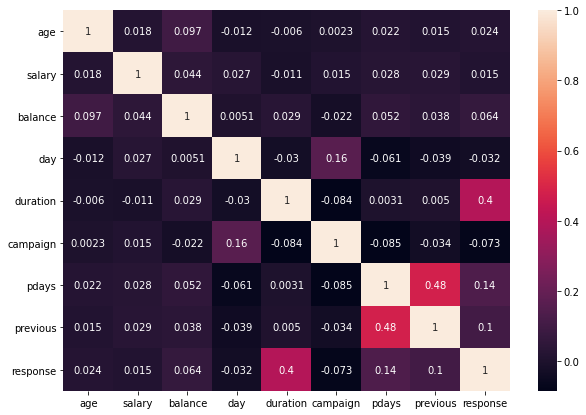

In [15]:
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(dataset_new.corr(), annot=True)

day and campaign features are negatively correlated with response, where as duration is highly correlated. Drop the column with negative correlation

### Are the features about the previous campaign data useful?

No, because it is negatively correlated with the target variable. So need to remove it.

In [16]:
dataset_new.drop(columns='campaign', inplace=True)
dataset_new.drop(columns='day', inplace=True)

In [17]:
dataset_new.head()

age           job  salary  marital  education targeted default  balance  \
0   58    management  100000  married   tertiary      yes      no     2143   
1   44    technician   60000   single  secondary      yes      no       29   
2   33  entrepreneur  120000  married  secondary      yes      no        2   
3   47   blue-collar   20000  married    unknown       no      no     1506   
4   33       unknown       0   single    unknown       no      no        1   

  housing loan  contact month  duration  pdays  previous poutcome  response  
0     yes   no  unknown   may       261     -1         0  unknown         0  
1     yes   no  unknown   may       151     -1         0  unknown         0  
2     yes  yes  unknown   may        76     -1         0  unknown         0  
3     yes   no  unknown   may        92     -1         0  unknown         0  
4      no   no  unknown   may       198     -1         0  unknown         0

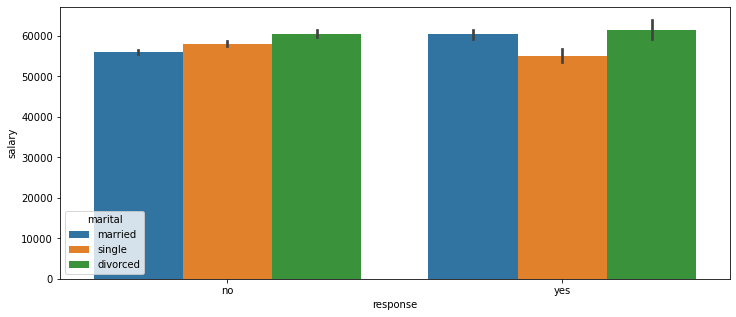

In [18]:
fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(dataset['response'],dataset['salary'], dataset['marital']);

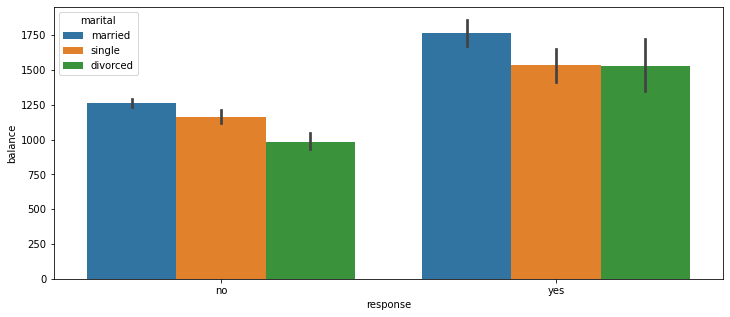

In [19]:
fig_dims = (12, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(dataset['response'],dataset['balance'], dataset['marital']);

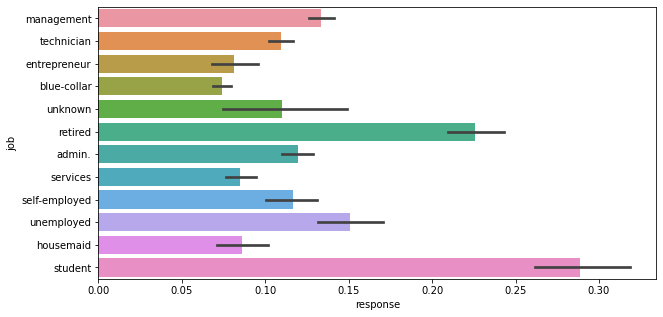

In [20]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(dataset_new['response'],dataset_new['job']);

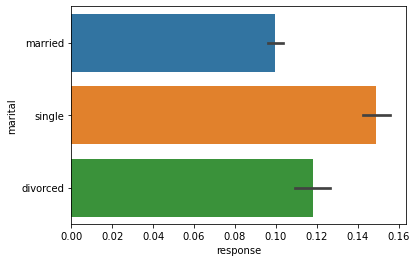

In [21]:
sns.barplot(dataset_new['response'],dataset_new['marital']);

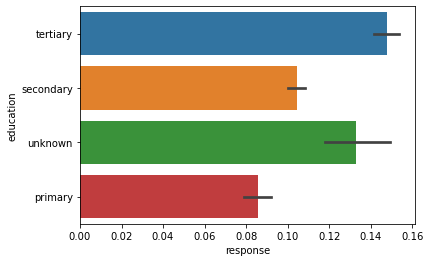

In [22]:
sns.barplot(dataset_new['response'],dataset_new['education']);

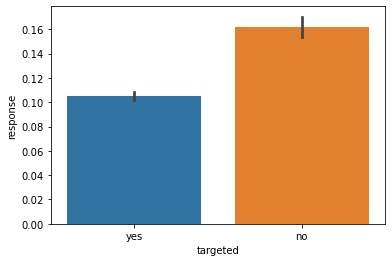

In [23]:
sns.barplot(dataset_new['targeted'], dataset_new['response']);

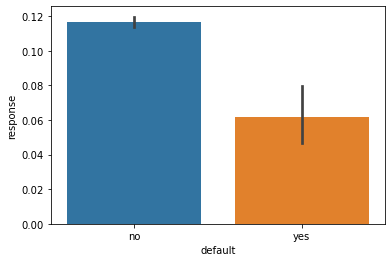

In [24]:
sns.barplot(dataset_new['default'], dataset_new['response']);

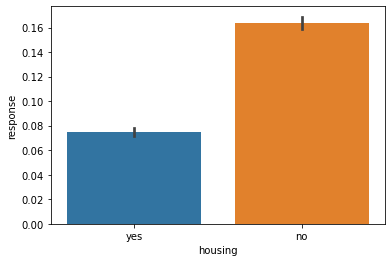

In [25]:
sns.barplot(dataset_new['housing'], dataset_new['response']);

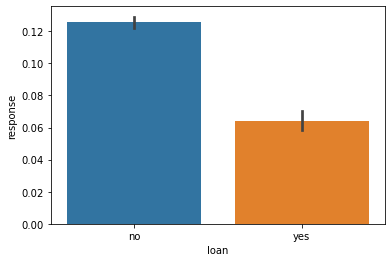

In [26]:
sns.barplot(dataset_new['loan'], dataset_new['response']);

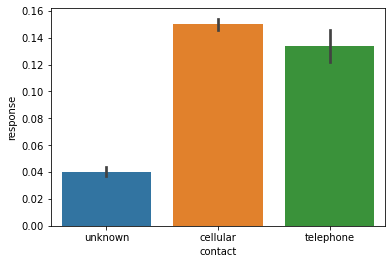

In [27]:
sns.barplot(dataset_new['contact'], dataset_new['response']);

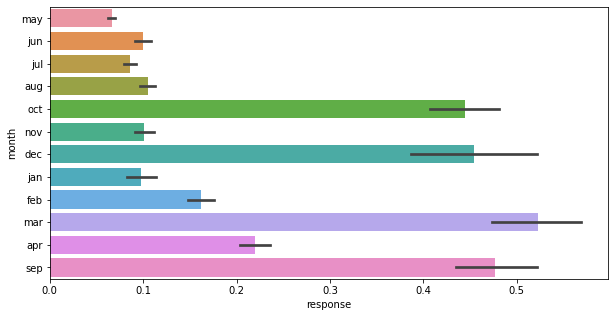

In [28]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(dataset_new['response'], dataset_new['month']);

### Are pdays and poutcome associated with the target?

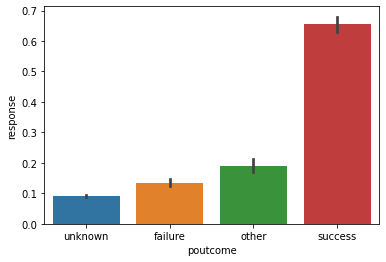

In [29]:
sns.barplot(dataset_new['poutcome'], dataset_new['response']);

Yes, as we have seen pdays have positive correlation with the target variable and poutcome is highly effective in plotting the relation with target variable. So both are important for our analysis.

### Let's create age group

In [30]:
def age_group(x):
    if x > 0 and x <=20:
        return '0-20'
    if x > 20 and x <=30:
        return '21-30'
    if x > 30 and x <=60:
        return '31-60'
    if x > 60:
        return 'above 60'

In [31]:
dataset_new['age_group'] = dataset_new['age'].apply(age_group)

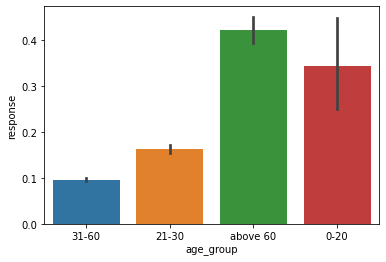

In [32]:
sns.barplot(dataset_new['age_group'], dataset_new['response'])

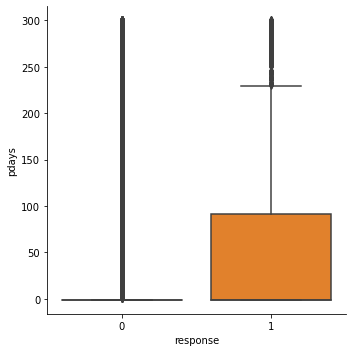

In [33]:
sns.catplot(x="response", y="pdays", data=dataset_new, kind="box")

Let's create a pairplot for overall view

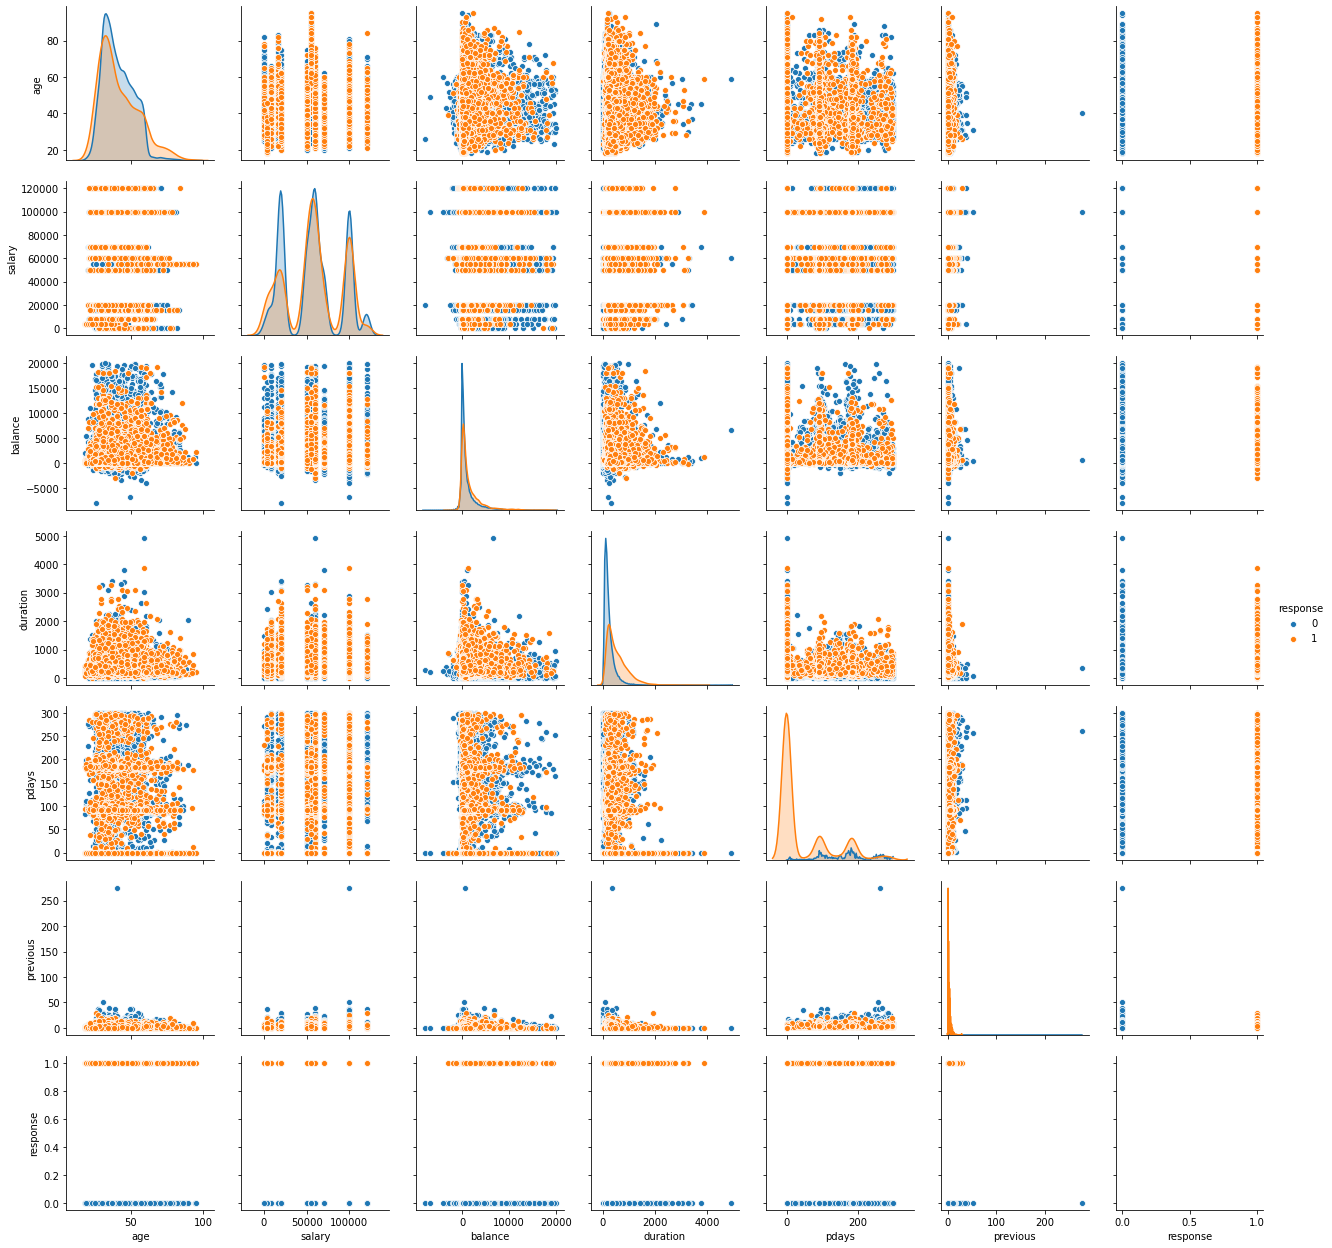

In [34]:
sns.pairplot(dataset_new, hue='response')

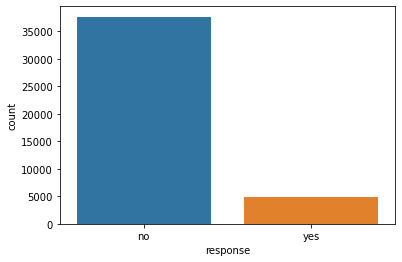

In [35]:
sns.countplot(dataset['response'])

Lets's select same number of samples for both the response, in order to mitigate overfitting.

In [36]:
dataset_new['response'].value_counts()

0    37638
1     4919
Name: response, dtype: int64

In [37]:
response_no = dataset_new[dataset_new['response'] == 0]
response_no = response_no.iloc[:4919, :]
response_yes = dataset_new[dataset_new['response'] == 1]
stratified_dataset = pd.concat([response_yes, response_no])
stratified_dataset = stratified_dataset.sample(frac=1)

In [38]:
dataset_new = stratified_dataset

In [39]:
dataset_new[dataset_new['pdays'] < 0]

age          job  salary   marital  education targeted default  \
3409    53      retired   55000   married   tertiary      yes      no   
4536    33   management  100000    single    primary      yes      no   
44551   67    housemaid   16000  divorced  secondary      yes      no   
42048   60  blue-collar   20000   married    primary      yes      no   
2006    29     services   70000    single  secondary      yes      no   
...    ...          ...     ...       ...        ...      ...     ...   
26110   32  blue-collar   20000   married  secondary      yes      no   
3123    38  blue-collar   20000   married  secondary      yes      no   
31030   31   management  100000   married   tertiary      yes      no   
4819    32   management  100000   married   tertiary      yes      no   
7555    40   technician   60000    single  secondary      yes      no   

       balance housing loan   contact month  duration  pdays  previous  \
3409        74     yes   no   unknown   may       122     -1         0   
4536      4897     yes   no   unknown   may       151     -1         0   
44551     5275      no   no  cellular   aug       222     -1         0   
42048        5      no   no  cellular   oct       401     -1         0   
2006       487     yes  yes   unknown   may       176     -1         0   
...        ...     ...  ...       ...   ...       ...    ...       ...   
26110      254     yes   no  cellular   nov      1720     -1         0   
3123       360     yes   no   unknown   may       220     -1         0   
31030        3     yes  yes  cellular   feb       331     -1         0   
4819         0     yes   no   unknown   may        91     -1         0   
7555      5637     yes   no   unknown   may       553     -1         0   

      poutcome  response age_group  
3409   unknown         0     31-60  
4536   unknown         0     31-60  
44551  unknown         1  above 60  
42048  unknown         1     31-60  
2006   unknown         0     21-30  
...        ...       ...       ...  
26110  unknown         1     31-60  
3123   unknown         0     31-60  
31030  unknown         1     31-60  
4819   unknown         0     31-60  
7555   unknown         1     31-60  

[8287 rows x 18 columns]

Let's convert pdays -1 to 0

In [40]:
def convertpdays(x):
    if x == -1:
        return 0
    else:
        return x

In [41]:
dataset_new['pdays'] = dataset_new['pdays'].apply(convertpdays)

### Encode Categorical Variables

In [42]:
#Label encoding
dataset_new['targeted'] = l.fit_transform(dataset_new['targeted'])
dataset_new['default'] = l.fit_transform(dataset_new['default'])
dataset_new['housing'] = l.fit_transform(dataset_new['housing'])
dataset_new['loan'] = l.fit_transform(dataset_new['loan'])

In [43]:
#Onehot encoding
dataset_new = pd.get_dummies(dataset_new)

In [44]:
dataset_new.head()

age  salary  targeted  default  balance  housing  loan  duration  \
3409    53   55000         1        0       74        1     0       122   
44256   27   50000         1        0     2855        0     0       138   
4536    33  100000         1        0     4897        1     0       151   
44551   67   16000         1        0     5275        0     0       222   
42977   61   55000         1        0     2557        1     0       158   

       pdays  previous  ...  month_oct  month_sep  poutcome_failure  \
3409       0         0  ...          0          0                 0   
44256    178         4  ...          0          0                 0   
4536       0         0  ...          0          0                 0   
44551      0         0  ...          0          0                 0   
42977     92         5  ...          0          0                 0   

       poutcome_other  poutcome_success  poutcome_unknown  age_group_0-20  \
3409                0                 0                 1               0   
44256               0                 1                 0               0   
4536                0                 0                 1               0   
44551               0                 0                 1               0   
42977               0                 1                 0               0   

       age_group_21-30  age_group_31-60  age_group_above 60  
3409                 0                1                   0  
44256                1                0                   0  
4536                 0                1                   0  
44551                0                0                   1  
42977                0                0                   1  

[5 rows x 53 columns]

Now let's divide the predict variable and target variable

In [45]:
X = dataset_new
y = dataset_new['response']

In [46]:
#Delete the response column from X
X.drop(columns=['response'], inplace=True)
print(X.columns)

Index(['age', 'salary', 'targeted', 'default', 'balance', 'housing', 'loan',
       'duration', 'pdays', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_group_0-20', 'age_group_21-30',
       'age_group_31-60', 'age_group_above 60'],
      dtype='object')


In [47]:
#Convert to numpy array 
# X = X.values

### Split into train and test set

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

### Scale the variables

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)

### Fit and predict

In [51]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Check Accuracy and classification report

In [52]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[945  16]
 [ 32 975]]


0.975609756097561

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       961
           1       0.98      0.97      0.98      1007

    accuracy                           0.98      1968
   macro avg       0.98      0.98      0.98      1968
weighted avg       0.98      0.98      0.98      1968



Here from the classification report we can see the precision, recall and f1-score is lesser than 0 as it was very poorly classified. It is because of less training data for the target 1, which was plotted before in the graph

## RFE Feature Selection

In [54]:
rfe = RFE(estimator=classifier, step=1)
rfe = rfe.fit(X_train, y_train)

### Feature Importance

In [55]:
selected_rfe_features = pd.DataFrame({'Features': list(X.columns), 'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

Features  Ranking
17         job_services        1
23      marital_married        1
22     marital_divorced        1
37            month_jul        1
27   education_tertiary        1
38            month_jun        1
39            month_mar        1
33            month_aug        1
40            month_may        1
41            month_nov        1
14       job_management        1
13        job_housemaid        1
42            month_oct        1
43            month_sep        1
28    education_unknown        1
9              previous        1
29     contact_cellular        1
7              duration        1
30    contact_telephone        1
31      contact_unknown        1
32            month_apr        1
47     poutcome_unknown        1
2              targeted        1
49      age_group_21-30        1
35            month_feb        1
36            month_jan        1
51   age_group_above 60        2
34            month_dec        3
46     poutcome_success        4
44     poutcome_failure        5
45       poutcome_other        6
5               housing        7
20       job_unemployed        8
10           job_admin.        9
24       marital_single       10
25    education_primary       11
26  education_secondary       12
21          job_unknown       13
4               balance       14
19       job_technician       15
6                  loan       16
1                salary       17
18          job_student       18
0                   age       19
50      age_group_31-60       20
8                 pdays       21
48       age_group_0-20       22
3               default       23
15          job_retired       24
12     job_entrepreneur       25
16    job_self-employed       26
11      job_blue-collar       27

In [56]:
rfecv = RFECV(estimator=classifier, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=0, solver='warn',
                                   tol=0.0001, verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [57]:
print('Optimal number of features: ', rfecv.n_features_)
print('Best features: ', X.columns[rfecv.support_])

Optimal number of features:  6
Best features:  Index(['duration', 'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_jun', 'month_may'],
      dtype='object')


In [58]:
rfecv.grid_scores_

array([0.94828267, 0.97445811, 0.97636368, 0.97623669, 0.97636368,
       0.97649082, 0.97623686, 0.97623686, 0.97623686, 0.97623686,
       0.97623686, 0.97623686, 0.97598289, 0.97585558, 0.97623694,
       0.97598281, 0.97585566, 0.97560153, 0.9757286 , 0.97534732,
       0.9757286 , 0.97560153, 0.97560153, 0.97547455, 0.97547455,
       0.97522042, 0.97534748, 0.97534748, 0.97534764, 0.97534748,
       0.9752205 , 0.97522034, 0.97534732, 0.97522034, 0.97522034,
       0.97522034, 0.97522034, 0.97522034, 0.97534748, 0.97534748,
       0.97534748, 0.97522042, 0.97534748, 0.97534748, 0.9752205 ,
       0.9752205 , 0.9752205 , 0.9752205 , 0.9752205 , 0.9752205 ,
       0.9752205 , 0.9752205 ])

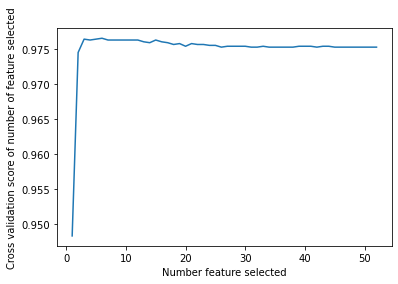

In [59]:
plt.figure()
plt.xlabel('Number feature selected')
plt.ylabel('Cross validation score of number of feature selected')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [60]:
selector = RFE(classifier, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

In [61]:
y_pred = selector.predict(X_test)

In [62]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[942  19]
 [ 35 972]]


0.9725609756097561

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       961
           1       0.98      0.97      0.97      1007

    accuracy                           0.97      1968
   macro avg       0.97      0.97      0.97      1968
weighted avg       0.97      0.97      0.97      1968



Still only with 3 features, we are getting good classification result

### K Folds Logistic Regression 

In [64]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 97.60 %
Standard Deviation: 0.66 %


### What is the precision, recall, accuracy of your model?

In [65]:
print("Precision: {:.2f} %".format(precision_score(y_test, y_pred)*100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_pred)*100))
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Precision: 98.08 %
Recall: 96.52 %
Accuracy: 97.26 %


## Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion='gini', random_state=0)

In [67]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [68]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[953   8]
 [ 39 968]]


0.9761178861788617

### What is the precision, recall, accuracy of your model?

In [69]:
print("Precision: {:.2f} %".format(precision_score(y_test, y_pred)*100))
print("Recall: {:.2f} %".format(recall_score(y_test, y_pred)*100))
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Precision: 99.18 %
Recall: 96.13 %
Accuracy: 97.61 %


### K Folds Random Forest Classification 

In [70]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 97.43 %
Standard Deviation: 0.63 %


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       961
           1       0.99      0.96      0.98      1007

    accuracy                           0.98      1968
   macro avg       0.98      0.98      0.98      1968
weighted avg       0.98      0.98      0.98      1968



### Random Forest Feature Importance

In [72]:
# check Important features
feature_importances_df = pd.DataFrame({"feature": list(X.columns),
                                       "importance": classifier.feature_importances_}).sort_values("importance", ascending=False)

# Display
feature_importances_df

feature  importance
40            month_may    0.289712
31      contact_unknown    0.200434
7              duration    0.130760
29     contact_cellular    0.121764
47     poutcome_unknown    0.041042
8                 pdays    0.033302
5               housing    0.031100
0                   age    0.025513
9              previous    0.021999
4               balance    0.018938
46     poutcome_success    0.014695
38            month_jun    0.013900
35            month_feb    0.005898
32            month_apr    0.004908
50      age_group_31-60    0.004012
11      job_blue-collar    0.003292
42            month_oct    0.003021
49      age_group_21-30    0.002807
27   education_tertiary    0.002431
1                salary    0.002313
51   age_group_above 60    0.002034
24       marital_single    0.001892
6                  loan    0.001783
33            month_aug    0.001653
37            month_jul    0.001505
26  education_secondary    0.001450
44     poutcome_failure    0.001430
30    contact_telephone    0.001339
23      marital_married    0.001309
41            month_nov    0.001269
25    education_primary    0.001262
19       job_technician    0.001047
10           job_admin.    0.001012
22     marital_divorced    0.000985
17         job_services    0.000912
2              targeted    0.000900
16    job_self-employed    0.000865
39            month_mar    0.000864
14       job_management    0.000824
15          job_retired    0.000737
3               default    0.000616
28    education_unknown    0.000517
12     job_entrepreneur    0.000516
36            month_jan    0.000435
34            month_dec    0.000253
13        job_housemaid    0.000225
20       job_unemployed    0.000202
18          job_student    0.000126
21          job_unknown    0.000102
43            month_sep    0.000095
45       poutcome_other    0.000000
48       age_group_0-20    0.000000

Here, the Logistic Regression classifier and Random Forest both are performing good. As both have very good accuracy and F1-score

Feature importance we got using RFE and Random Forest seems to be different.